## Simulating the Wealth Distribution

This notebook contains the code for simulating wealth dynamics.  Savings follows an ad hoc rule.

Code is provided for implementing Lorenz curves and the Gini coefficient.

Author: John Stachurski

Date: September 2018



In [1]:
from numba import jit, njit, vectorize, prange
import numpy as np
from numpy import exp, log

import statsmodels.api as sm

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

/home/john/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The model is 

$$ w' = R' s(w) + y' $$

where the $R, y$ process is iid with

$$ 
    R = (1 + r) \exp(\mu_r + \sigma_r \xi),
    \quad
    \xi \sim N(0, 1)
$$

and

$$
    y = \exp(\mu_y + \sigma_y \zeta),
    \quad
    \zeta \sim N(0, 1)
$$

For convenience, $\mu_y$ is just `mu` and $\sigma_y$ is just `sigma`

In [2]:
@njit
def s(w, s_0=0.75):
    """
    The savings function
    """
    if w < 1.0:
        return 0
    else:
        return s_0 * w



Here's code for updating a household one period and for simulating the wealth time series for an individual household.

In [3]:
@njit
def update(w, mu, sigma, r, sigma_r):
    
    mu_r = - sigma_r**2 / 2  # maintain unit mean):
    R = (1 + r) * exp(mu_r + sigma_r * np.random.randn())
    y = exp(mu + sigma * np.random.randn())
    return R * s(w) + y

In [4]:
@njit
def gen_wealth_ts(w_init=0.0, 
                  n=2000,
                  sigma=1.5,
                  mu=1.5,
                  r=0.1,
                  sigma_r=1.0):

    w = np.empty(n)
    w[0] = w_init

    for t in range(n-1):
        w[t+1] = update(w[t], mu, sigma, r, sigma_r)
    return w

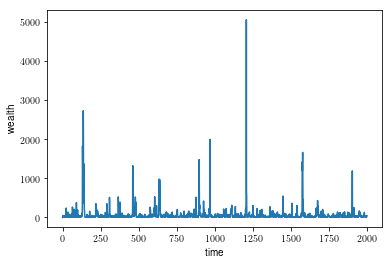

In [5]:
w = gen_wealth_ts()

fig, ax = plt.subplots()
ax.plot(w, label="$w_t$")
ax.set_xlabel("time")
ax.set_ylabel("wealth")
plt.show()

Here's code for generating an entire cross section of households at a given point in time.

In [6]:
@njit
def gen_cross_section(w_init=np.zeros(2000), 
                      n=200,
                      sigma=1.5,
                      mu=1.5,
                      r=0.1,
                      sigma_r=1.0,
                      seed=1234):

    np.random.seed(seed)
    w_out = np.empty_like(w_init)
    
    for i, w in enumerate(w_init):
        for t in range(n-1):
            w = update(w, mu, sigma, r, sigma_r)
        w_out[i] = w
        
    return w_out

### Lorenz curves

In [7]:
@njit
def lorenz(y):
    n = len(y)
    y = np.sort(y)
    s = np.zeros(n+1)
    s[1:] = np.cumsum(y)
    f_vals = np.zeros(n+1)
    l_vals = np.zeros(n+1)
    for i in range(1, n+1):
        f_vals[i] = i/n
        l_vals[i] = s[i] / s[n]
    return f_vals, l_vals


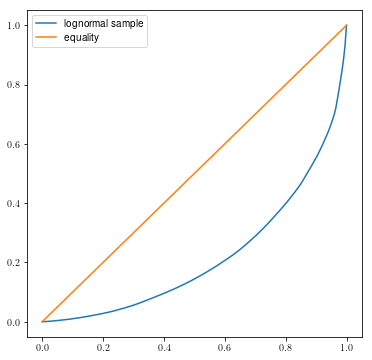

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

f_vals, l_vals = lorenz(exp(np.random.randn(200)))
ax.plot(f_vals, l_vals, label=f'lognormal sample')
    
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

#### default params

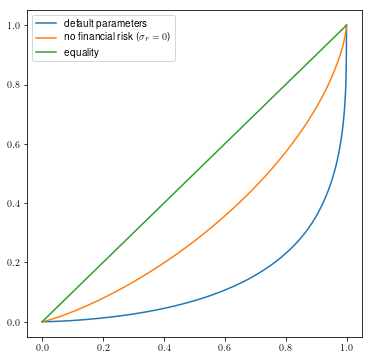

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

f_vals, l_vals = lorenz(gen_cross_section(w_init=np.zeros(20000)))
ax.plot(f_vals, l_vals, label=f'default parameters')

f_vals, l_vals = lorenz(gen_cross_section(sigma_r=0.0, w_init=np.zeros(20000)))
ax.plot(f_vals, l_vals, label='no financial risk ($\\sigma_r = 0$)')
    
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

#### income, mean

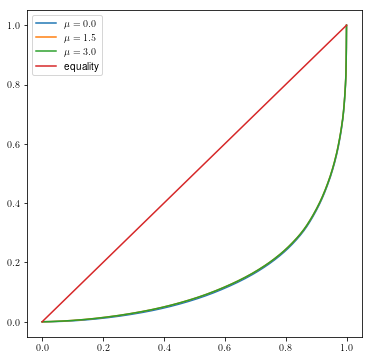

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
mu_vals = [0.0, 1.5, 3.0]

for mu in mu_vals:
    
    w_dist = gen_cross_section(mu=mu)
    f_vals, l_vals = lorenz(w_dist)

    ax.plot(f_vals, l_vals, 
            label=f'$\mu = {mu:0.2}$')
    
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

#### income, variance

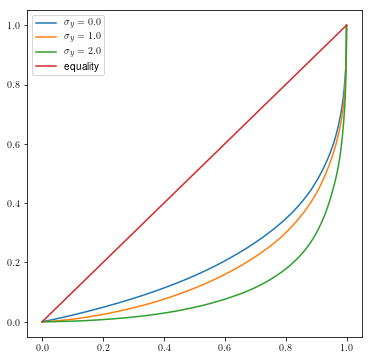

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
sigma_vals = [0.0, 1.0, 2.0]

for sigma in sigma_vals:
    
    w_dist = gen_cross_section(sigma=sigma)
    f_vals, l_vals = lorenz(w_dist)

    ax.plot(f_vals, l_vals, 
            label=f'$\sigma_y = {sigma:0.2}$')
    
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

#### increasing rate of return

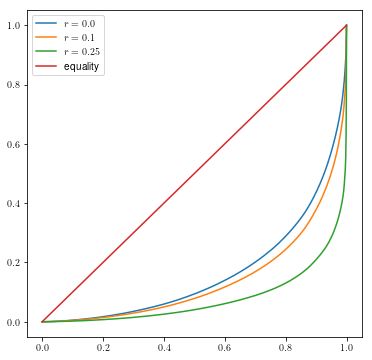

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
r_vals = [0.0, 0.1, 0.25]

for r in r_vals:
    
    w_dist = gen_cross_section(r=r)
    f_vals, l_vals = lorenz(w_dist)

    ax.plot(f_vals, l_vals, 
            label=f'$r = {r:0.2}$')
    
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

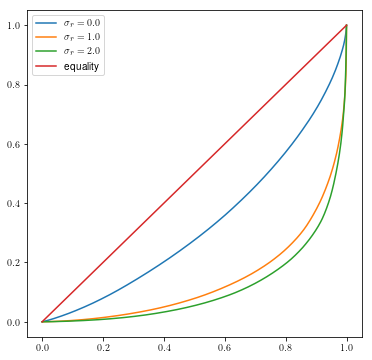

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
sigma_r_vals = [0.0, 1.0, 2.0]

for sigma_r in sigma_r_vals:
    
    w_dist = gen_cross_section(sigma_r=sigma_r)
    f_vals, l_vals = lorenz(w_dist)

    ax.plot(f_vals, l_vals, 
            label=f'$\sigma_r = {sigma_r:0.2}$')
    
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

## Gini

In [14]:
@njit(parallel=True)
def gini(y):
    n = len(y)
    i_sum = np.zeros(n)
    for i in prange(n):
        for j in range(n):
            i_sum[i] += abs(y[i] - y[j])
    return np.sum(i_sum) / (2 * n * np.sum(y))

#### how does the interest rate affect inequality?

depends on its volatility?

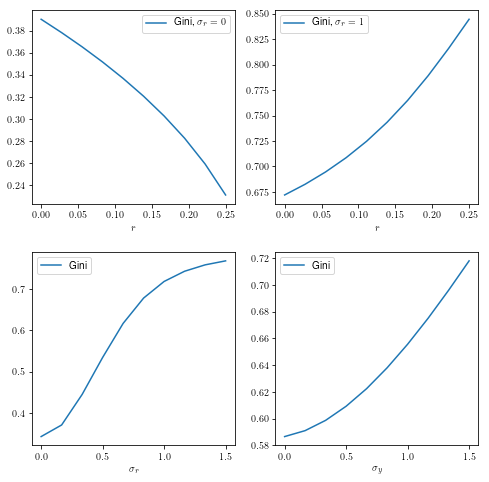

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

ax = axes[0]

r_vals = np.linspace(0, 0.25, 10)
g_vals = []
for r in r_vals:
    w_dist = gen_cross_section(sigma_r=0.0, r=r)
    g_vals.append(gini(w_dist))
    
ax.plot(r_vals, g_vals, label="Gini, $\sigma_r=0$")
ax.set_xlabel("$r$")
ax.legend()



ax = axes[1]

r_vals = np.linspace(0, 0.25, 10)
g_vals = []
for r in r_vals:
    w_dist = gen_cross_section(sigma_r=1.0, r=r)
    g_vals.append(gini(w_dist))
    
ax.plot(r_vals, g_vals, label="Gini, $\sigma_r=1$")
ax.set_xlabel("$r$")
ax.legend()



ax = axes[2]

sigma_r_vals = np.linspace(0.0, 1.5, 10)
g_vals = []
for sigma_r in sigma_r_vals:
    w_dist = gen_cross_section(sigma_r=sigma_r)
    g_vals.append(gini(w_dist))
    
ax.plot(sigma_r_vals, g_vals, label="Gini")
ax.set_xlabel("$\\sigma_r$")
ax.legend()


ax = axes[3]

sigma_vals = np.linspace(0.0, 1.5, 10)
g_vals = []
for sigma in sigma_vals:
    w_dist = gen_cross_section(sigma=sigma)
    g_vals.append(gini(w_dist))
    
ax.plot(sigma_vals, g_vals, label="Gini")
ax.set_xlabel("$\\sigma_y$")
ax.legend()

fig.subplots_adjust(wspace=0.2, hspace=0.25)

plt.show()

#### contour plots

In [ ]:
g_size = 16
xgrid = np.linspace(0.0, 1.5, g_size)  # sigma_r
ygrid = np.linspace(0.0, 1.5, g_size)  # sigma
X, Y = np.meshgrid(xgrid, ygrid)

Z = np.empty((g_size, g_size))

for i in range(g_size):
    for j in range(g_size):
        w_dist = gen_cross_section(sigma_r=xgrid[i], sigma=ygrid[j])
        Z[i, j] = gini(w_dist)
Z = Z.T

In [ ]:
fig, ax = plt.subplots(figsize=(9.5, 7))

cs1 = ax.contourf(X, Y, Z, alpha=0.65)
ctr1 = ax.contour(X, Y, Z, colors='black', alpha=0.75)

plt.clabel(ctr1, inline=1, fontsize=10)
plt.colorbar(cs1, ax=ax, format="%.4f")


#ax.grid(True)
ax.set_xlabel('$\\sigma_r$', fontsize=16)
ax.set_ylabel("$\\sigma_y$", fontsize=16)

plt.show()

### shifting means

In [ ]:
g_size = 10
xgrid = np.linspace(0.0, 3.0, g_size)   # mu
ygrid = np.linspace(0.0, 1.5, g_size)  # sigma

X, Y = np.meshgrid(xgrid, ygrid)

Z = np.empty((g_size, g_size))

for i in range(g_size):
    for j in range(g_size):
        w_dist = gen_cross_section(mu=xgrid[i], sigma=ygrid[j])
        Z[i, j] = gini(w_dist)
Z = Z.T

In [ ]:
fig, ax = plt.subplots(figsize=(9.5, 7))

cs1 = ax.contourf(X, Y, Z, cmap=cm.jet, alpha=0.45)
ctr1 = ax.contour(X, Y, Z, colors='black', alpha=0.75)

plt.clabel(ctr1, inline=1, fontsize=10)
plt.colorbar(cs1, ax=ax, format="%.4f")


#ax.grid(True)
ax.set_xlabel('$\\mu_y$', fontsize=16)
ax.set_ylabel("$\\sigma_y$", fontsize=16)

plt.show()

In [22]:
g_size = 10
xgrid = np.linspace(0.0, 1.5, g_size)  # sigma_r
ygrid = np.linspace(0.0, 0.25, g_size)  # r
X, Y = np.meshgrid(xgrid, ygrid)

Z = np.empty((g_size, g_size))

for i in range(g_size):
    for j in range(g_size):
        w_dist = gen_cross_section(sigma_r=xgrid[i], r=ygrid[j])
        Z[i, j] = gini(w_dist)
Z = Z.T

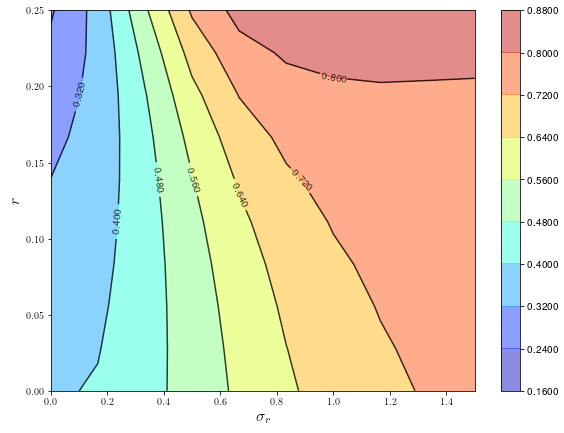

In [23]:
fig, ax = plt.subplots(figsize=(9.5, 7))

cs1 = ax.contourf(X, Y, Z, cmap=cm.jet, alpha=0.45)
ctr1 = ax.contour(X, Y, Z, colors='black', alpha=0.75)

plt.clabel(ctr1, inline=1, fontsize=10)
plt.colorbar(cs1, ax=ax, format="%.4f")


#ax.grid(True)
ax.set_xlabel('$\\sigma_r$', fontsize=16)
ax.set_ylabel("$r$", fontsize=16)

plt.show()

### Size rank plots

In [24]:
def size_rank_data(w_dist, c=0.5):
    """
    Generate size-rank data corresponding to distribution w_dist
    """
    w = - np.sort(- w_dist) # Reverse sort
    w = w[:int(len(w) * c)] # extract top x%
    ydata = np.log(np.arange(len(w)) + 1)
    xdata = np.log(w)
    x = sm.add_constant(xdata)
    reg1 = sm.OLS(ydata, x)
    results = reg1.fit()
    a = abs(results.params[1])
    return xdata, ydata, a

#### first for some fixed distributions:

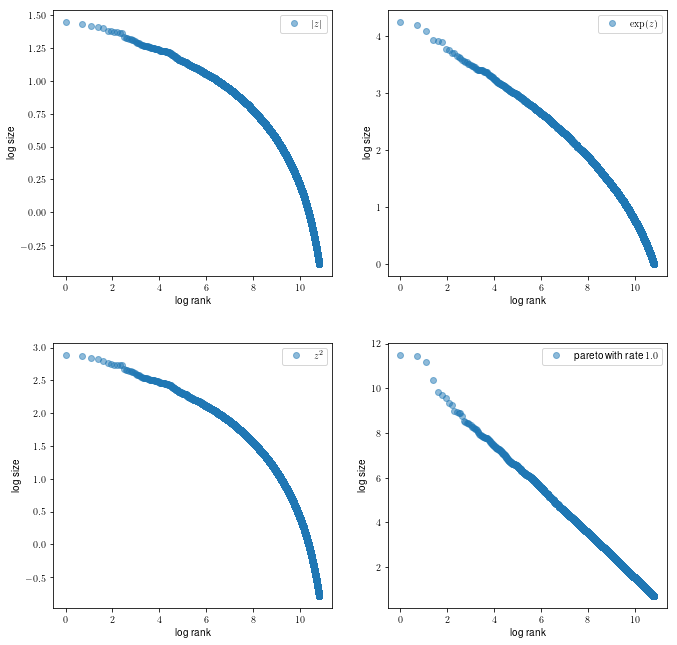

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(11, 11))
axes = axes.flatten()

ax = axes[0]


sz = 100000
z = np.random.randn(sz)

xdata, ydata, a = size_rank_data(np.abs(z))
ax.plot(ydata, xdata, 'o', alpha=0.5, label='$|z|$')


ax.set_xlabel("log rank")
ax.set_ylabel("log size")
ax.legend()


ax = axes[1]

xdata, ydata, a = size_rank_data(np.exp(z))
ax.plot(ydata, xdata, 'o', alpha=0.5, label='$\\exp(z)$')


ax.set_xlabel("log rank")
ax.set_ylabel("log size")

ax.legend()


ax = axes[2]

xdata, ydata, a = size_rank_data(z**2)
ax.plot(ydata, xdata, 'o', alpha=0.5, label='$z^2$')


ax.set_xlabel("log rank")
ax.set_ylabel("log size")

ax.legend()


ax = axes[3]


y = np.random.exponential(scale=1.0, size=sz)
xdata, ydata, a = size_rank_data(np.exp(y))
ax.plot(ydata, xdata, 'o', alpha=0.5, label='pareto with rate $1.0$')

ax.set_xlabel("log rank")
ax.set_ylabel("log size")

ax.legend()


fig.subplots_adjust(wspace=0.2, hspace=0.25)

plt.show()

#### data from the model

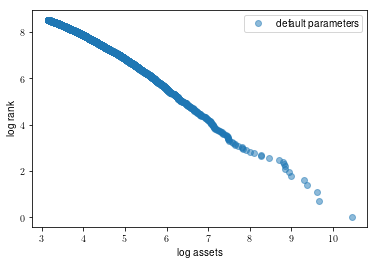

In [26]:

fig, ax = plt.subplots()


w_dist = gen_cross_section(w_init=np.zeros(10000))
xdata, ydata, a = size_rank_data(w_dist)
ax.plot(xdata, ydata, 'o', alpha=0.5, label=f'default parameters')

ax.set_ylabel("log rank")
ax.set_xlabel("log assets")

ax.legend()

plt.show()

shutting down financial income risk:

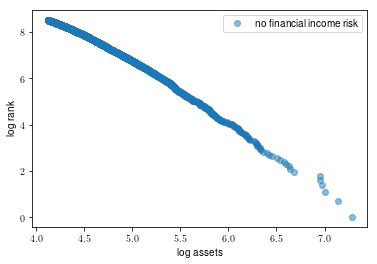

In [30]:

fig, ax = plt.subplots()


w_dist = gen_cross_section(w_init=np.zeros(10000), sigma_r=0)
xdata, ydata, a = size_rank_data(w_dist)
ax.plot(xdata, ydata, 'o', alpha=0.5, label=f'no financial income risk')

ax.set_ylabel("log rank")
ax.set_xlabel("log assets")

ax.legend()

plt.show()

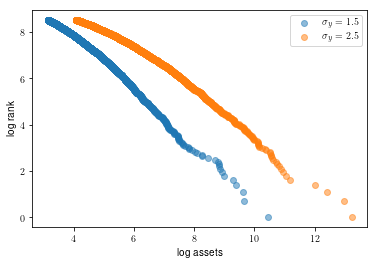

In [27]:

sigma_vals = 1.5, 2.5
fig, ax = plt.subplots()

for sigma in sigma_vals:
    w_dist = gen_cross_section(w_init=np.zeros(10000), sigma=sigma)
    xdata, ydata, a = size_rank_data(w_dist)
    ax.plot(xdata, ydata, 'o', alpha=0.5, label=f'$\\sigma_y = {sigma}$')

ax.set_ylabel("log rank")
ax.set_xlabel("log assets")

ax.legend()

plt.show()

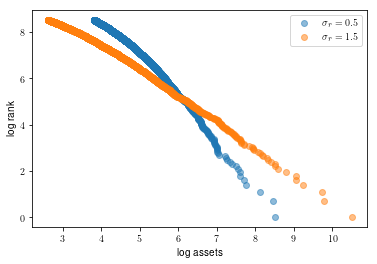

In [28]:

sigma_r_vals = 0.5, 1.5
fig, ax = plt.subplots()

for sigma_r in sigma_r_vals:
    w_dist = gen_cross_section(w_init=np.zeros(10000), sigma_r=sigma_r)
    xdata, ydata, a = size_rank_data(w_dist)
    ax.plot(xdata, ydata, 'o', alpha=0.5, label=f'$\\sigma_r = {sigma_r}$')

ax.set_ylabel("log rank")
ax.set_xlabel("log assets")

ax.legend()

plt.show()